
# Zeitreihenvorhersage mit RNNs in Keras

RNNs zur Vorhersage von Zeitreihendaten mittels Keras.
Die Daten sind Zufallsdaten

In [1]:
# setup
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# make a sample multivariable time series - not autoregressive
# generate a random walk
def random_walk(steps, scale = 1):
    w = np.zeros(steps)
    for x in range(1,steps):
        w[x] = w[x-1] + scale * np.random.normal()
    return(w)
        
time_steps = 5000
data = pd.DataFrame({'x' : range(time_steps), 'y' : np.arange(time_steps) ** (1/2) + random_walk(time_steps) })
data = data.assign(z = np.log(data.x+1) + 0.3 * data.y)
data_mat = np.array(data)


Using TensorFlow backend.


Die Daten sehen folgendermassen aus:

In [2]:
print(data_mat)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 8.61481923e-01 9.51591757e-01]
 [2.00000000e+00 1.27164301e+00 1.48010519e+00]
 ...
 [4.99700000e+03 9.25294582e+01 3.62756306e+01]
 [4.99800000e+03 9.22662842e+01 3.61968784e+01]
 [4.99900000e+03 9.28179990e+01 3.63625929e+01]]


Folgend müssen die Daten etwas aufgeplittet werden in Test und Trainingsdaten:

In [3]:
# split into samples (sliding time windows)
samples = list()
target = list()
length = 50

# step over the 5,000 in jumps of length
for i in range(time_steps - length - 1):
  # grab from i to i + length
    sample = data_mat[i:i+length,:2]
    outcome = data_mat[i+length+1,2]
    target.append(outcome)
    samples.append(sample)

# split out a test set
test_size = 1000
x_test_mat = np.dstack(samples[-test_size:])
x_test_3d_final = np.moveaxis(x_test_mat, [0, 1, 2], [1, 2, 0] )

# The RNN needs data with the format of [samples, time steps, features].
# Here, we have N samples, 50 time steps per sample, and 2 features
data_mat_stacked = np.dstack(samples[:-test_size])
data_mat_3d_final = np.moveaxis(data_mat_stacked, [0, 1, 2], [1, 2, 0] )

# and fix up the target
target_arr = np.array(target[:-test_size])

Das Model wird dann relativ einfach mit Keras und SimpleRNN gebildet:

Train on 3159 samples, validate on 790 samples
Epoch 1/20
 - 7s - loss: 11817.8916 - mse: 11817.8955 - val_loss: 5.0170 - val_mse: 5.0170
Epoch 2/20
 - 6s - loss: 136.2487 - mse: 136.2487 - val_loss: 6.0740 - val_mse: 6.0740
Epoch 3/20
 - 5s - loss: 95.5780 - mse: 95.5780 - val_loss: 6.8136 - val_mse: 6.8136
Epoch 4/20
 - 4s - loss: 82.2111 - mse: 82.2111 - val_loss: 35.7897 - val_mse: 35.7897
Epoch 5/20
 - 5s - loss: 71.4356 - mse: 71.4355 - val_loss: 6.4766 - val_mse: 6.4766
Epoch 6/20
 - 5s - loss: 65.3842 - mse: 65.3842 - val_loss: 4.6228 - val_mse: 4.6228
Epoch 7/20
 - 5s - loss: 56.3644 - mse: 56.3644 - val_loss: 4.7170 - val_mse: 4.7170
Epoch 8/20
 - 5s - loss: 58.8166 - mse: 58.8166 - val_loss: 9.1293 - val_mse: 9.1293
Epoch 9/20
 - 5s - loss: 57.7315 - mse: 57.7314 - val_loss: 8.1003 - val_mse: 8.1003
Epoch 10/20
 - 5s - loss: 55.6285 - mse: 55.6285 - val_loss: 4.0319 - val_mse: 4.0319
Epoch 11/20
 - 5s - loss: 53.0174 - mse: 53.0174 - val_loss: 9.2775 - val_mse: 9.2775
Epoch 

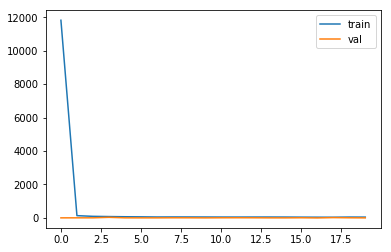

In [4]:
# now build the RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape = (data_mat_3d_final.shape[1], data_mat_3d_final.shape[2]), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
   
# compile the model    
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

# and train the model
history = model.fit(data_mat_3d_final, target_arr, epochs=20, batch_size=25, verbose=2, validation_split = 0.20)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Final kann man dann die Predictions und die Testdaten vergleichen:

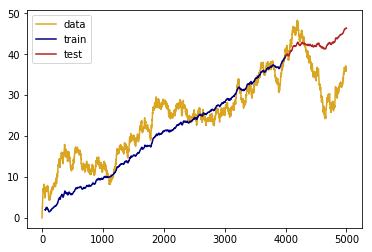

In [5]:
# get predictions
train_predictions = model.predict(data_mat_3d_final)
test_predictions = model.predict(x_test_3d_final)

# plot predictions vs actual
plt.plot(data['x'], data['z'], c = 'goldenrod', label = 'data')
plt.plot(data.iloc[(length+1):-test_size]['x'], train_predictions, c = 'navy', label = 'train')
plt.plot(data.iloc[-test_size:]['x'], test_predictions, c = 'firebrick', label = 'test')
plt.legend(loc='best')
plt.show()